In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

C:\Users\k12628\Anaconda3\envs\test\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [4]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [9]:
INIT_LR = 1e-2
EPOCHS = 10
BS = 16
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
  ...
    to  
  ['...']
Train for 191 steps, validate on 767 samples
Epoch 1/10
191/191 [==============================] - 378s 2s/step - loss: 0.6248 - accuracy: 0.8403 - val_loss: 0.4684 - val_accuracy: 0.8258
Epoch 2/10
191/191 [==============================] - 375s 2s/step - loss: 0.2740 - accuracy: 0.8862 - val_loss: 0.5247 - val_accuracy: 0.8511
Epoch 3/10
191/191 [==============================] - 372s 2s/step - loss: 0.2112 - accuracy: 0.9174 - val_loss: 0.5252 - val_accuracy: 0.8404
Epoch 4/10
191/191 [==============================] - 372s 2s/step - loss: 0.2145 - accuracy: 0.9170 - val_loss: 0.1682 - val_accuracy: 0.9136
Epoch 5/10
191/191 [==============================] - 373s 2s/step - loss: 0.1927 - accuracy: 0.9305 - val_loss: 0.3042 - val_accuracy: 0.8777
Epoch 6/10
191/191 [==============================] - 383s 2s/step - loss: 0.1807 - accuracy: 0.9246 - val_loss: 0.1385 - val_accuracy: 0.9388
Epoch 7/10
191/191 [==

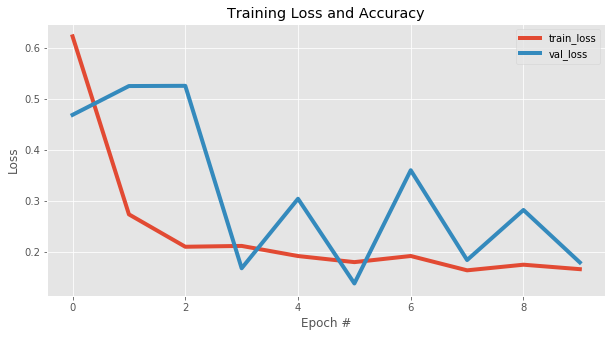

In [19]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss",linewidth=4)
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss",linewidth=4)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

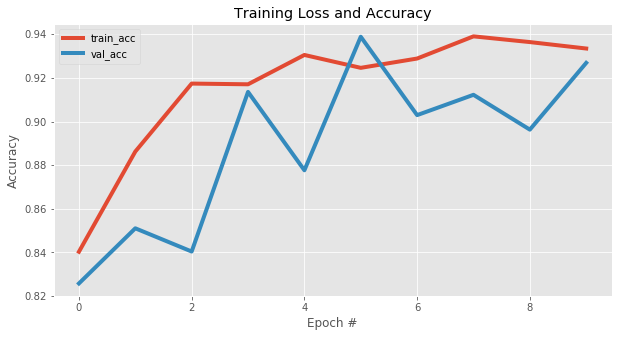

In [20]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc",linewidth=4)
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc",linewidth=4)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

In [12]:
model.save('mask_recog_ver2.h5')